In [126]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import os
import shutil
from keci_r_MRR import Keci_exp
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
random.seed(0)

In [52]:
# Generate left out data used for prediction (This has been done turn by turn for each dataset)

values_to_include =[(4,1,2)] #[(0,0,4), (0,4,4), (1,2,0), (4,1,2), (4,2,1), (0,1,0), (0,0,3)]

pred_data = {}
occurrences_count = {value: 0 for value in values_to_include}

for key, value in data_dict.items():
    if value in values_to_include and occurrences_count[value] < 300:
        pred_data[key] = value
        occurrences_count[value] += 1

# Remove the extracted elements from the original dictionary
for key in pred_data:
    del data_dict[key]

print(len(pred_data))

300


In [54]:
#Generate test data

random_keys = random.sample(list(data_dict.keys()), 200)
test_data = {key: data_dict.pop(key) for key in random_keys}
print(len(test_data))

# Modelling

## LSTM

In [88]:
class MyMultiClassClassifier_lstm(nn.Module):
    def __init__(self, num_classes):
        super(MyMultiClassClassifier_lstm, self).__init__()
        self.lstm = nn.LSTM(5000,256,num_layers=2)
        
        self.fc3_p = nn.Linear(256, 3*num_classes)
        # self.fc3_q = nn.Linear(256, num_classes)
        # self.fc3_r = nn.Linear(256, num_classes)

    def forward(self, x):
        output1, (hn1, cn1) = self.lstm(x.reshape(1,48,5000))
        output1 = output1.sum(1)
        output = torch.relu(output1)
        
        output = self.fc3_p(output)

        return output.reshape(-1,5,3)

num_classes = 5
input_size = 5000 * 48

multi_class_classifier_lstm = MyMultiClassClassifier_lstm(num_classes)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(multi_class_classifier_lstm.parameters(), lr=0.001)

loss_lstm = []
num_epochs = 150

for epoch in range(num_epochs):
    total_loss = 0  # to monitor the loss

    for D_i, target_triple in data_dict.items():
        D_i_flat = D_i.view(-1)
        target_p, target_q, target_r = target_triple
        
        p_q_r = multi_class_classifier_lstm(D_i_flat)
       
        loss = criterion(p_q_r, torch.tensor(torch.tensor([target_p,target_q,target_r]), dtype=torch.long).unsqueeze(0))
        
        total_loss +=loss.item()
        
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
        

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')
    loss_lstm.append(total_loss)
        


/tmp/ipykernel_2230923/3573386890.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(p_q_r, torch.tensor(torch.tensor([target_p,target_q,target_r]), dtype=torch.long).unsqueeze(0))


Epoch [1/150], Loss: 753.6534
Epoch [2/150], Loss: 668.4742
Epoch [3/150], Loss: 606.5065
Epoch [4/150], Loss: 563.6023
Epoch [5/150], Loss: 526.4786
Epoch [6/150], Loss: 490.1487
Epoch [7/150], Loss: 453.0331
Epoch [8/150], Loss: 415.1502
Epoch [9/150], Loss: 376.9977
Epoch [10/150], Loss: 339.7404
Epoch [11/150], Loss: 304.6809
Epoch [12/150], Loss: 272.4497
Epoch [13/150], Loss: 242.6075
Epoch [14/150], Loss: 215.2803
Epoch [15/150], Loss: 190.8946
Epoch [16/150], Loss: 169.6428
Epoch [17/150], Loss: 151.0203
Epoch [18/150], Loss: 135.0970
Epoch [19/150], Loss: 121.4626
Epoch [20/150], Loss: 109.8998
Epoch [21/150], Loss: 100.0712
Epoch [22/150], Loss: 91.5758
Epoch [23/150], Loss: 84.1502
Epoch [24/150], Loss: 77.6849
Epoch [25/150], Loss: 71.9474
Epoch [26/150], Loss: 66.7828
Epoch [27/150], Loss: 62.1701
Epoch [28/150], Loss: 57.9547
Epoch [29/150], Loss: 54.1030
Epoch [30/150], Loss: 50.5783
Epoch [31/150], Loss: 47.3404
Epoch [32/150], Loss: 44.3534
Epoch [33/150], Loss: 41.605

In [89]:
len(loss_lstm)

150

In [90]:
        
# Test the model with train data first
# data = data_dict

data = test_data
#data = pred_data
with torch.no_grad():
    s = 0 
    for D_i, target in data.items():
        D_i_flat = D_i.view(-1)
        target = torch.tensor(target)
        outputs = multi_class_classifier_lstm(D_i_flat)
    
        p,q,r = outputs.argmax(1).squeeze(0)
        
        p_q_r = (p.item(),q.item(),r.item())
        
        if p_q_r == tuple(target.numpy()):
            s += 1 
            
        print(f'Predicted: {p_q_r}, Actual: {tuple(target.numpy())}')
print(f'the model is able to predict with { s/(len(data))*100} percent')

Predicted: (1, 2, 0), Actual: (4, 2, 1)
Predicted: (0, 0, 0), Actual: (0, 0, 3)
Predicted: (0, 1, 0), Actual: (0, 1, 0)
Predicted: (0, 4, 4), Actual: (0, 4, 4)
Predicted: (1, 2, 0), Actual: (4, 2, 1)
Predicted: (1, 2, 0), Actual: (0, 4, 4)
Predicted: (0, 0, 3), Actual: (0, 0, 3)
Predicted: (0, 2, 4), Actual: (4, 2, 1)
Predicted: (0, 4, 4), Actual: (0, 0, 4)
Predicted: (0, 4, 4), Actual: (0, 4, 4)
Predicted: (0, 1, 0), Actual: (0, 1, 0)
Predicted: (0, 2, 4), Actual: (1, 2, 0)
Predicted: (4, 2, 1), Actual: (1, 2, 0)
Predicted: (4, 2, 1), Actual: (4, 2, 1)
Predicted: (0, 0, 3), Actual: (0, 0, 3)
Predicted: (0, 0, 4), Actual: (0, 0, 3)
Predicted: (0, 0, 0), Actual: (0, 0, 3)
Predicted: (0, 0, 3), Actual: (0, 0, 3)
Predicted: (0, 1, 0), Actual: (0, 1, 0)
Predicted: (0, 2, 0), Actual: (0, 0, 3)
Predicted: (0, 0, 4), Actual: (0, 0, 4)
Predicted: (0, 4, 4), Actual: (0, 4, 4)
Predicted: (4, 2, 1), Actual: (0, 4, 4)
Predicted: (0, 0, 3), Actual: (0, 0, 3)
Predicted: (0, 4, 4), Actual: (4, 2, 1)


## GRU

In [92]:
class MyMultiClassClassifier_gru(nn.Module):
    def __init__(self, num_classes):
        super(MyMultiClassClassifier_gru, self).__init__()
        self.gru = nn.GRU(5000,256,num_layers=2)
        
        self.fc3_p = nn.Linear(256, 3*num_classes)
    def forward(self, x):
        
        output1, hn1 = self.gru(x.reshape(1,48,5000))
        output1 = output1.sum(1)
        output = torch.relu(output1)
        
        output = self.fc3_p(output)

        return output.reshape(-1,5,3)

num_classes = 5
input_size = 5000 * 48

multi_class_classifier_gru = MyMultiClassClassifier_gru(num_classes)

loss_gru = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(multi_class_classifier_gru.parameters(), lr=0.001)


num_epochs = 150

for epoch in range(num_epochs):
    total_loss = 0  # to monitor the loss

    for D_i, target_triple in data_dict.items():
        D_i_flat = D_i.view(-1)
        target_p, target_q, target_r = target_triple
        
        p_q_r = multi_class_classifier_gru(D_i_flat)
        
       
        loss = criterion(p_q_r, torch.tensor(torch.tensor([target_p,target_q,target_r]), dtype=torch.long).unsqueeze(0))
        
        total_loss +=loss.item()
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
        

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')
        loss_gru.append(total_loss)

/tmp/ipykernel_2230923/4221610534.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(p_q_r, torch.tensor(torch.tensor([target_p,target_q,target_r]), dtype=torch.long).unsqueeze(0))


Epoch [1/150], Loss: 441.9413
Epoch [2/150], Loss: 374.5903
Epoch [3/150], Loss: 307.4259
Epoch [4/150], Loss: 250.7930
Epoch [5/150], Loss: 203.4949
Epoch [6/150], Loss: 166.1220
Epoch [7/150], Loss: 136.9144
Epoch [8/150], Loss: 114.7943
Epoch [9/150], Loss: 98.2594
Epoch [10/150], Loss: 85.5097
Epoch [11/150], Loss: 75.3745
Epoch [12/150], Loss: 67.1343
Epoch [13/150], Loss: 60.3429
Epoch [14/150], Loss: 54.6755
Epoch [15/150], Loss: 49.8317
Epoch [16/150], Loss: 45.5790
Epoch [17/150], Loss: 41.8163
Epoch [18/150], Loss: 38.4762
Epoch [19/150], Loss: 35.4721
Epoch [20/150], Loss: 32.7683
Epoch [21/150], Loss: 30.3389
Epoch [22/150], Loss: 28.0900
Epoch [23/150], Loss: 26.0468
Epoch [24/150], Loss: 24.1656
Epoch [25/150], Loss: 22.4410
Epoch [26/150], Loss: 20.8776
Epoch [27/150], Loss: 19.4340
Epoch [28/150], Loss: 18.1080
Epoch [29/150], Loss: 16.9081
Epoch [30/150], Loss: 15.7891
Epoch [31/150], Loss: 14.7580
Epoch [32/150], Loss: 13.7967
Epoch [33/150], Loss: 12.9066
Epoch [34/1

In [93]:
        
# Test the model with train data first
# data = data_dict

data = test_data
#data = pred_data
with torch.no_grad():
    s = 0 
    for D_i, target in data.items():
        D_i_flat = D_i.view(-1)
        target = torch.tensor(target)
        outputs = multi_class_classifier_gru(D_i_flat)
    
        p,q,r = outputs.argmax(1).squeeze(0)
        
        p_q_r = (p.item(),q.item(),r.item())
        
        if p_q_r == tuple(target.numpy()):
            s += 1 
            
        print(f'Predicted: {p_q_r}, Actual: {tuple(target.numpy())}')
print(f'the model is able to predict with { s/(len(data))*100} percent')

Predicted: (0, 2, 1), Actual: (4, 2, 1)
Predicted: (0, 0, 3), Actual: (0, 0, 3)
Predicted: (0, 0, 0), Actual: (0, 1, 0)
Predicted: (0, 0, 4), Actual: (0, 4, 4)
Predicted: (1, 2, 0), Actual: (4, 2, 1)
Predicted: (0, 0, 4), Actual: (0, 4, 4)
Predicted: (0, 0, 3), Actual: (0, 0, 3)
Predicted: (0, 4, 4), Actual: (4, 2, 1)
Predicted: (0, 4, 4), Actual: (0, 0, 4)
Predicted: (0, 4, 4), Actual: (0, 4, 4)
Predicted: (0, 1, 0), Actual: (0, 1, 0)
Predicted: (0, 4, 4), Actual: (1, 2, 0)
Predicted: (4, 2, 1), Actual: (1, 2, 0)
Predicted: (1, 2, 0), Actual: (4, 2, 1)
Predicted: (0, 1, 0), Actual: (0, 0, 3)
Predicted: (0, 0, 4), Actual: (0, 0, 3)
Predicted: (0, 1, 0), Actual: (0, 0, 3)
Predicted: (0, 0, 0), Actual: (0, 0, 3)
Predicted: (0, 1, 0), Actual: (0, 1, 0)
Predicted: (0, 2, 0), Actual: (0, 0, 3)
Predicted: (0, 0, 4), Actual: (0, 0, 4)
Predicted: (0, 4, 4), Actual: (0, 4, 4)
Predicted: (4, 2, 1), Actual: (0, 4, 4)
Predicted: (0, 0, 3), Actual: (0, 0, 3)
Predicted: (4, 2, 4), Actual: (4, 2, 1)


# Concatenate to predict simultaneously

In [94]:
class MyMultiClassClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MyMultiClassClassifier, self).__init__()
        self.gru = nn.GRU(5000,256,num_layers=2)
        self.lstm = nn.LSTM(5000,256,num_layers=2)
        # self.fc2 = nn.Linear(64, 32)
        self.fc3_p = nn.Linear(2*256, 3*num_classes)
        

    def forward(self, x):
        output1, hn1 = self.gru(x.reshape(1,48,5000))
        output2, (hn2, cn2) = self.lstm(x.reshape(1,48,5000))
        output1 = output1.sum(1)
        output2 = output2.sum(1)
        output = torch.concatenate([output1,output2], 1)
        output = torch.relu(output)
        
        #x = torch.relu(self.fc2(x))
        output = self.fc3_p(output)
       
        return output.reshape(-1,5,3)

# Assuming 5 classes (0 to 4 for each of p, q, r)
num_classes = 5
input_size = 5000 * 48    #(Nx3d dimension matrix)

multi_class_classifier_model = MyMultiClassClassifier(num_classes)


criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(multi_class_classifier_model.parameters(), lr=0.001)
num_epochs = 150
loss_concat = []
for epoch in range(num_epochs):
    total_loss = 0  # to monitor the loss

    for D_i, target_triple in data_dict.items():
        D_i_flat = D_i.view(-1)
        target_p, target_q, target_r = target_triple

       
        p_q_r = multi_class_classifier_model(D_i_flat)

       
        loss = criterion(p_q_r, torch.tensor(torch.tensor([target_p,target_q,target_r]), dtype=torch.long).unsqueeze(0))
        
        total_loss +=loss.item()
        
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')
        loss_concat.append(total_loss)


/tmp/ipykernel_2230923/679499654.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(p_q_r, torch.tensor(torch.tensor([target_p,target_q,target_r]), dtype=torch.long).unsqueeze(0))


Epoch [1/150], Loss: 380.5985
Epoch [2/150], Loss: 346.7325
Epoch [3/150], Loss: 299.4430
Epoch [4/150], Loss: 256.5110
Epoch [5/150], Loss: 215.9307
Epoch [6/150], Loss: 180.7755
Epoch [7/150], Loss: 150.8835
Epoch [8/150], Loss: 127.2010
Epoch [9/150], Loss: 108.7470
Epoch [10/150], Loss: 94.9260
Epoch [17/150], Loss: 46.1978
Epoch [18/150], Loss: 42.4529
Epoch [19/150], Loss: 39.0816
Epoch [20/150], Loss: 36.0850
Epoch [21/150], Loss: 33.3356
Epoch [22/150], Loss: 30.8277
Epoch [23/150], Loss: 28.5177
Epoch [24/150], Loss: 26.4124
Epoch [25/150], Loss: 24.4864
Epoch [26/150], Loss: 22.7019
Epoch [27/150], Loss: 21.0697
Epoch [28/150], Loss: 19.5587
Epoch [29/150], Loss: 18.1777
Epoch [30/150], Loss: 16.9095
Epoch [31/150], Loss: 15.7488
Epoch [32/150], Loss: 14.6761
Epoch [33/150], Loss: 13.6854
Epoch [34/150], Loss: 12.7656
Epoch [35/150], Loss: 11.9121
Epoch [36/150], Loss: 11.1211
Epoch [37/150], Loss: 10.3761
Epoch [38/150], Loss: 9.6827
Epoch [39/150], Loss: 9.0274
Epoch [40/15

In [98]:
        
# Test the model with train data first
# data = data_dict

data = test_data
# data = pred_data
with torch.no_grad():
    s = 0 
    for D_i, target in data.items():
        D_i_flat = D_i.view(-1)
        target = torch.tensor(target)
        outputs = multi_class_classifier_model(D_i_flat)
    
        p,q,r = outputs.argmax(1).squeeze(0)
        
        p_q_r = (p.item(),q.item(),r.item())
        
        if p_q_r == tuple(target.numpy()):
            s += 1 
            
        print(f'Predicted: {p_q_r}, Actual: {tuple(target.numpy())}')
print(f'the model is able to predict with { s/(len(data))*100} percent')

Predicted: (0, 2, 0), Actual: (4, 2, 1)
Predicted: (0, 0, 3), Actual: (0, 0, 3)
Predicted: (0, 0, 3), Actual: (0, 1, 0)
Predicted: (0, 4, 4), Actual: (0, 4, 4)
Predicted: (1, 2, 4), Actual: (4, 2, 1)
Predicted: (0, 2, 4), Actual: (0, 4, 4)
Predicted: (0, 0, 4), Actual: (0, 0, 3)
Predicted: (0, 4, 4), Actual: (4, 2, 1)
Predicted: (0, 4, 4), Actual: (0, 0, 4)
Predicted: (4, 2, 1), Actual: (0, 4, 4)
Predicted: (0, 1, 0), Actual: (0, 1, 0)
Predicted: (0, 2, 4), Actual: (1, 2, 0)
Predicted: (4, 2, 1), Actual: (1, 2, 0)
Predicted: (1, 2, 1), Actual: (4, 2, 1)
Predicted: (0, 0, 0), Actual: (0, 0, 3)
Predicted: (0, 0, 0), Actual: (0, 0, 3)
Predicted: (0, 0, 3), Actual: (0, 0, 3)
Predicted: (0, 0, 3), Actual: (0, 0, 3)
Predicted: (0, 1, 0), Actual: (0, 1, 0)
Predicted: (4, 2, 0), Actual: (0, 0, 3)
Predicted: (0, 0, 4), Actual: (0, 0, 4)
Predicted: (0, 4, 4), Actual: (0, 4, 4)
Predicted: (0, 2, 4), Actual: (0, 4, 4)
Predicted: (0, 0, 3), Actual: (0, 0, 3)
Predicted: (1, 2, 4), Actual: (4, 2, 1)


# Assembling LSTM, GRU and Concat

In [122]:
# Test the model with train data first
# data = data_dict
data = test_data
#data = pred_data

#define the weights for the assembling
a = 0.75
b = 0.2
c = 1-a-b

ss = 0
score, dataset = (4,1,2), 'FB15k' #left out dataset 
with torch.no_grad():
    s = 0 
    i = 0
    m = []
    pred = []
    for D_i, target in data.items():
        D_i_flat = D_i.view(-1)
        target = torch.tensor(target)
        outputs1 = multi_class_classifier_lstm(D_i_flat)
        outputs2 = multi_class_classifier_gru(D_i_flat)
        outputs3 = multi_class_classifier_model(D_i_flat)
        
        outputs1 = outputs1.squeeze(0)
        outputs2 = outputs2.squeeze(0)
        outputs3 = outputs3.reshape(5,3)
        
        
        p1,q1,r1 = outputs1[:,0], outputs1[:,1], outputs1[:,2]
        p2,q2,r2 = outputs2[:,0], outputs2[:,1], outputs2[:,2]
        
        p3,q3,r3 = outputs3[:,0], outputs3[:,1], outputs3[:,2]
        
        p = a*p1+b*p2 + c*p3 
        q = a*q1+b*q2 + c*q3
        r = a*r1+b*r2 + c*r3
        
        p= torch.softmax(p,0).argmax(0)
        q= torch.softmax(q,0).argmax(0)
        r= torch.softmax(r,0).argmax(0)
        
        
        p_q_r = (p.item(),q.item(),r.item())
        
        if tuple(target.numpy()) == score:
            pred.append(p_q_r)
        
        if ((p_q_r == score) and (tuple(target.numpy()) == score)):
            ss+=1
            
        # if ((p_q_r != score) and (tuple(target.numpy()) == score)):
        #     m.append(p_q_r) #extract false positive triples (eg: the model predicted (0,0,1) instead of (0,1,0))
    
        
        if p_q_r == tuple(target.numpy()):
            s += 1 
            
        # print(f'Predicted: {p_q_r}, Actual: {tuple(target.numpy())}')
print(f'the model is able to predict with { s/(len(data))*100} percent')
# print(ss) 
# print(f'm_{dataset} = {m}')
#print(f'pred_{dataset} = {pred}')

the model is able to predict with 45.0 percent


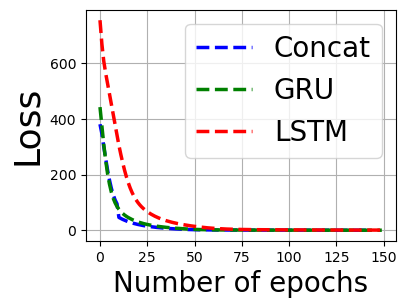

In [183]:
plt.figure(figsize=(4, 3))

plt.plot(loss_concat,'--b', linewidth = 2.5)
plt.plot(loss_gru,'--g', linewidth = 2.5)
plt.plot(loss_lstm,'--r', linewidth = 2.5)
plt.legend(['Concat','GRU', 'LSTM'], fontsize = 20)
plt.xlabel('Number of epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 26)
plt.grid()

plt.savefig('AAAAA.pdf', bbox_inches='tight')  # Specify the filename
plt.show()


# with PdfPages('AAAAA.pdf') as pdf:
#     pdf.savefig(AAAAA)


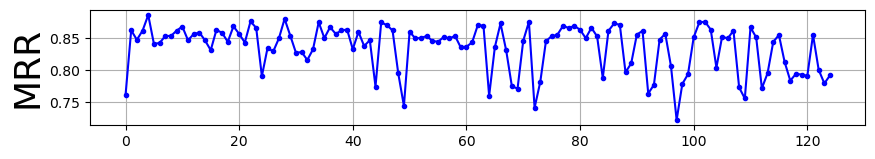

In [190]:
l_UMLS = [(0, 0, 0, 0.760275910907946), (0, 0, 1, 0.862229000778265), (0, 0, 2, 0.847344843367232), (0, 0, 3, 0.8615240687227784), (0, 0, 4, 0.8860335825703147), (0, 1, 0, 0.8410411483389052), (0, 1, 1, 0.8422898680155887), (0, 1, 2, 0.8532997026992168), (0, 1, 3, 0.8533437777189904), (0, 1, 4, 0.8616491071838286), (0, 2, 0, 0.8680325898919706), (0, 2, 1, 0.8465739244125556), (0, 2, 2, 0.8563098935692324), (0, 2, 3, 0.8587118141565244), (0, 2, 4, 0.8463189189085363), (0, 3, 0, 0.8310852915363337), (0, 3, 1, 0.8627462986062845), (0, 3, 2, 0.858209767013325), (0, 3, 3, 0.84411741381356), (0, 3, 4, 0.8684288363271512), (0, 4, 0, 0.8565114944949549), (0, 4, 1, 0.8430583166781902), (0, 4, 2, 0.875933626157362), (0, 4, 3, 0.8660626183259119), (0, 4, 4, 0.7904911584156828), (1, 0, 0, 0.8345858331319158), (1, 0, 1, 0.8290638372948682), (1, 0, 2, 0.8496088095698351), (1, 0, 3, 0.8800515113404744), (1, 0, 4, 0.853838021450744), (1, 1, 0, 0.8269957636749112), (1, 1, 1, 0.8281741731662684), (1, 1, 2, 0.81574670852512), (1, 1, 3, 0.8324084878716717), (1, 1, 4, 0.874802619867001), (1, 2, 0, 0.8499241303024414), (1, 2, 1, 0.866974985175783), (1, 2, 2, 0.8565911952863915), (1, 2, 3, 0.8618783165241926), (1, 2, 4, 0.8634113413469774), (1, 3, 0, 0.8325477324861398), (1, 3, 1, 0.8596351796394212), (1, 3, 2, 0.8375923840734821), (1, 3, 3, 0.8466595498924637), (1, 3, 4, 0.7741863025302355), (1, 4, 0, 0.8744075533193798), (1, 4, 1, 0.8703413388748277), (1, 4, 2, 0.8619258829088289), (1, 4, 3, 0.7950820845148011), (1, 4, 4, 0.7439202043700484), (2, 0, 0, 0.859884782711585), (2, 0, 1, 0.8496479237637672), (2, 0, 2, 0.8500634261022122), (2, 0, 3, 0.8532528142433634), (2, 0, 4, 0.8457164155408384), (2, 1, 0, 0.8441325324156124), (2, 1, 1, 0.8516628833672049), (2, 1, 2, 0.8494311311737645), (2, 1, 3, 0.8533905816860125), (2, 1, 4, 0.8354785976845163), (2, 2, 0, 0.836528997281592), (2, 2, 1, 0.8431284502243321), (2, 2, 2, 0.8701203427951945), (2, 2, 3, 0.8694574610408072), (2, 2, 4, 0.7597119518681906), (2, 3, 0, 0.8356354230786348), (2, 3, 1, 0.8728155173706473), (2, 3, 2, 0.8306614110656458), (2, 3, 3, 0.7747271950210397), (2, 3, 4, 0.7710263955271583), (2, 4, 0, 0.8458425625913123), (2, 4, 1, 0.8753927614986484), (2, 4, 2, 0.7410682402719259), (2, 4, 3, 0.7815668833690336), (2, 4, 4, 0.8454593924948682), (3, 0, 0, 0.8528226518496842), (3, 0, 1, 0.8550812487146976), (3, 0, 2, 0.8691285799303342), (3, 0, 3, 0.8658256468267105), (3, 0, 4, 0.8689137556761258), (3, 1, 0, 0.8631341107685665), (3, 1, 1, 0.8498495405705275), (3, 1, 2, 0.8660271148163033), (3, 1, 3, 0.8526676097939123), (3, 1, 4, 0.7877072228025567), (3, 2, 0, 0.8613507793502249), (3, 2, 1, 0.8728821257692595), (3, 2, 2, 0.870755188149104), (3, 2, 3, 0.7965719327002163), (3, 2, 4, 0.8104317816306914), (3, 3, 0, 0.8555549184957711), (3, 3, 1, 0.8612468074934252), (3, 3, 2, 0.7633279594833156), (3, 3, 3, 0.7768915432332466), (3, 3, 4, 0.8475603753936408), (3, 4, 0, 0.8567752320488278), (3, 4, 1, 0.8062792608581694), (3, 4, 2, 0.7219243657735646), (3, 4, 3, 0.7783389398382022), (3, 4, 4, 0.7935538900078376), (4, 0, 0, 0.8511859319742767), (4, 0, 1, 0.8747517455780935), (4, 0, 2, 0.8754589560872349), (4, 0, 3, 0.8633193145860292), (4, 0, 4, 0.803811778806831), (4, 1, 0, 0.852159864952638), (4, 1, 1, 0.8494864040097024), (4, 1, 2, 0.8617039263980638), (4, 1, 3, 0.772779998033765), (4, 1, 4, 0.7556050703219983), (4, 2, 0, 0.8666358913276776), (4, 2, 1, 0.8510576740640554), (4, 2, 2, 0.7714989563495686), (4, 2, 3, 0.7950203638063116), (4, 2, 4, 0.8439636579177954), (4, 3, 0, 0.8548472313561037), (4, 3, 1, 0.8128656557862864), (4, 3, 2, 0.7835019026348693), (4, 3, 3, 0.7941074211758173), (4, 3, 4, 0.7929811658297832), (4, 4, 0, 0.7909921023757506), (4, 4, 1, 0.8550057470675408), (4, 4, 2, 0.8003844173583224), (4, 4, 3, 0.7791112046470429), (4, 4, 4, 0.7919423348487613)]

#plot MRR values of UMLS
l = l_UMLS
mrr_values = [item[-1] for item in l]
triples = [(item[0], item[1], item[2]) for item in l]
x_labels = range(0,len(mrr_values))#[str(triple) for triple in triples]


plt.figure(figsize=(10,1.5))

plt.plot(x_labels,mrr_values, '.-b', linewidth=1.5)

# ax.set_xlim(0, data.shape[1])
# ax.set_ylim(0, data.shape[0])

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter("{x:,.2f}"))
plt.ylabel('MRR', fontsize=26)
#plt.title('MRR Values for UMLS')
plt.grid()
plt.savefig('exhaus_UMLS.pdf',bbox_inches='tight')
plt.show()